In [396]:
%reload_ext autoreload
%autoreload 2

In [397]:
from finargy.api.client import InvertirOnlineAPI
from finargy.api.account_data import (
    get_account_movements,
    get_portfolio,
    get_account_movements_finished,
)
from finargy.api.market_data.symbol_data import get_symbol_history
import pandas as pd
import numpy as np
from dotenv import load_dotenv
import os
import datetime
import requests

In [398]:
client = InvertirOnlineAPI()

In [399]:
# print(client.access_token)

In [400]:
# movements_data = get_account_movements_finished(client=client, date_start="2021-01-01")

In [508]:
from finargy.portfolio.portfolio_reconstruction import parse_movements

movements_df = parse_movements(movements_data)

In [509]:
# filter only tipo = 'compra' and 'venta'
movements_df = movements_df[movements_df["tipo"].isin(["Compra", "Venta"])].reset_index(
    drop=True
)

In [510]:
movements_df.columns

Index(['numero', 'fechaOrden', 'tipo', 'estado', 'mercado', 'simbolo',
       'cantidad', 'monto', 'modalidad', 'precio', 'fechaOperada',
       'cantidadOperada', 'precioOperado', 'montoOperado', 'plazo',
       'fecha_orden', 'fecha_operada'],
      dtype='object')

In [511]:
# generate calendar_df

# convert to datetime
movements_df["fecha_operada"] = pd.to_datetime(movements_df["fecha_operada"])

start_date = movements_df["fecha_operada"].min()
end_date = pd.to_datetime(datetime.datetime.now().date())
calendar_df = pd.DataFrame(
    pd.date_range(start=start_date, end=end_date, freq="D"), columns=["fecha"]
)


# now generate this calendar for each unique asset in the movements_df using the min and max for each asset. If max is not available then propage until current date.

# get unique assets
assets = movements_df["simbolo"].unique()
assets_df = pd.DataFrame(assets, columns=["simbolo"])

# perform a cross join to generate calendar for each asset

df_combo = pd.merge(calendar_df, assets_df, how="cross")


# filter by min_date for each asset
min_date = (
    movements_df.groupby("simbolo")["fecha_operada"]
    .min()
    .reset_index()
    .rename(columns={"fecha_operada": "min_date"})
)

df_combo = pd.merge(df_combo, min_date, on="simbolo", how="left")

df_combo = df_combo[df_combo["fecha"] >= df_combo["min_date"]].reset_index(drop=True)

df_combo.rename(columns={"fecha": "fecha_operada"}, inplace=True)

In [512]:
# read cedear ratio correction data

cedear_ratio_df = pd.read_csv(
    "data/portfolio/ajustes_cedears.csv",
    parse_dates=["fecha_operada"],
    date_format="%d/%m/%Y",
    usecols=["fecha_operada", "simbolo", "cantidad_correccion", "in_out", "market"],
)
cedear_ratio_df

# if out change sign
cedear_ratio_df["cantidad_correccion"] = np.where(
    cedear_ratio_df["in_out"] == "OUT",
    -cedear_ratio_df["cantidad_correccion"],
    cedear_ratio_df["cantidad_correccion"],
)

cedear_ratio_df

,in_out,market,simbolo,cantidad_correccion,fecha_operada
0,IN,BCBA,BIOX,80,2024-01-26
1,IN,BCBA,VIST,48,2024-01-26
2,IN,BCBA,MELI,17,2024-01-26
3,IN,BCBA,AAPL,49,2024-01-26
4,IN,BCBA,V,20,2022-11-22
5,IN,BCBA,META,20,2022-11-22
6,IN,BCBA,RUC6O,1500,2022-11-02
7,OUT,BCBA,SUSCRP-MSU-6,-1500,2022-11-02
8,IN,BCBA,TSLA,40,2022-08-30
9,IN,BCBA,GOOGL,38,2022-07-21


In [513]:
# select relevant columns
movements_df = movements_df[
    [
        "tipo",
        "estado",
        "mercado",
        "simbolo",
        "cantidadOperada",
        "precioOperado",
        "montoOperado",
        "plazo",
        "fecha_orden",
        "fecha_operada",
    ]
].copy()

In [514]:
movements_df = pd.concat([movements_df, cedear_ratio_df], axis=0)

movements_df["cantidad_correccion"] = movements_df["cantidad_correccion"].fillna(0)

movements_df["cantidadOperada"] = movements_df["cantidadOperada"].fillna(0)


movements_df["cantidadOperada"] = (
    movements_df["cantidadOperada"] + movements_df["cantidad_correccion"]
)

In [515]:
df_combo["fecha"] = pd.to_datetime(df_combo["fecha_operada"])
movements_df["fecha_operada"] = pd.to_datetime(movements_df["fecha_operada"])

# tipo == Venta then add - quantity
movements_df["cantidadOperada"] = np.where(
    movements_df["tipo"] == "Venta",
    -1 * movements_df["cantidadOperada"],
    movements_df["cantidadOperada"],
)


# Sort both dataframes by symbol and date
movements_df = movements_df.sort_values(["simbolo", "fecha_operada"]).reset_index(
    drop=True
)

df_combo = df_combo.sort_values(["simbolo", "fecha_operada"]).reset_index(drop=True)
# Calculate cumulative quantity (cum_qty)
movements_df["cum_qty"] = movements_df.groupby("simbolo")["cantidadOperada"].cumsum()

In [516]:
movements_df[movements_df["simbolo"] == "VIST"]

,tipo,estado,mercado,simbolo,cantidadOperada,precioOperado,montoOperado,plazo,fecha_orden,fecha_operada,in_out,market,cantidad_correccion,cum_qty
144,Compra,terminada,BCBA,VIST,7.0,7040.5,49283.5,a48horas,2023-03-10,2023-03-10,NaN,NaN,0.0,7.0
145,Compra,terminada,BCBA,VIST,5.0,9834.0,49170.0,a48horas,2023-05-12,2023-05-12,NaN,NaN,0.0,12.0
146,Compra,terminada,BCBA,VIST,12.0,11583.5,139002.0,a48horas,2023-06-08,2023-06-08,NaN,NaN,0.0,24.0
147,NaN,NaN,NaN,VIST,48.0,NaN,NaN,NaN,NaN,2024-01-26,IN,BCBA,48.0,72.0
148,Compra,terminada,BCBA,VIST,71.0,13048.5,926443.5,a48horas,2024-03-05,2024-03-05,NaN,NaN,0.0,143.0
149,Compra,terminada,BCBA,VIST,16.0,15130.0,242080.0,a48horas,2024-04-25,2024-04-25,NaN,NaN,0.0,159.0
150,Compra,terminada,BCBA,VIST,26.0,18576.0,482976.0,a24horas,2024-06-04,2024-06-04,NaN,NaN,0.0,185.0
151,Compra,terminada,BCBA,VIST,24.0,20770.0,498480.0,a24horas,2024-07-01,2024-07-01,NaN,NaN,0.0,209.0
152,Compra,terminada,BCBA,VIST,23.0,17675.0,406525.0,a24horas,2024-08-02,2024-08-02,NaN,NaN,0.0,232.0
153,Compra,terminada,BCBA,VIST,20.0,21775.0,435500.0,a24horas,2024-09-03,2024-09-03,NaN,NaN,0.0,252.0


In [542]:
# Merge both dataframes using left join
df_merged = pd.merge(
    df_combo,
    movements_df,
    how="left",
    left_on=["simbolo", "fecha_operada"],
    right_on=["simbolo", "fecha_operada"],
)

In [543]:
# perform forward fill "cantidadOperada" of for each asset
df_merged["total_qty"] = df_merged.groupby("simbolo")["cum_qty"].ffill()

In [544]:
df_merged[df_merged["simbolo"] == "VIST"].reset_index().to_clipboard()

In [545]:
df_merged.columns

Index(['fecha_operada', 'simbolo', 'min_date', 'fecha', 'tipo', 'estado',
       'mercado', 'cantidadOperada', 'precioOperado', 'montoOperado', 'plazo',
       'fecha_orden', 'in_out', 'market', 'cantidad_correccion', 'cum_qty',
       'total_qty'],
      dtype='object')

In [546]:
# select relevant columns
df_merged = df_merged[
    [
        "fecha_operada",
        "cantidadOperada",
        "precioOperado",
        "montoOperado",
        "simbolo",
        "min_date",
        "market",
        "total_qty",
    ]
].copy()

In [547]:
from finargy.api.market_data.symbol_data import get_symbol_history

In [548]:
al30_data = get_symbol_history(
    client=client,
    symbol="AL30",
    date_start=datetime.datetime(2021, 1, 1),
    date_end=datetime.datetime.now(),
)

al30d_data = get_symbol_history(
    client=client,
    symbol="AL30D",
    date_start=datetime.datetime(2021, 1, 1),
    date_end=datetime.datetime.now(),
)

Authenticated. Token expires at 2024-09-09 00:03:18.909497


In [ ]:
from finargy.data_processing.utils import (
    get_end_of_day,
    parse_date_df,
    get_historical_series,
)

In [549]:
al30_df = get_historical_series(al30_data, "fechaHora")

al30d_df = get_historical_series(al30d_data, "fechaHora")


dolar_mep = pd.merge(
    al30_df, al30d_df, on="fechaHora_date", how="inner", suffixes=("_al30", "_al30d")
)

dolar_mep["dolar_mep"] = (
    dolar_mep["ultimoPrecio_al30"] / dolar_mep["ultimoPrecio_al30d"]
)

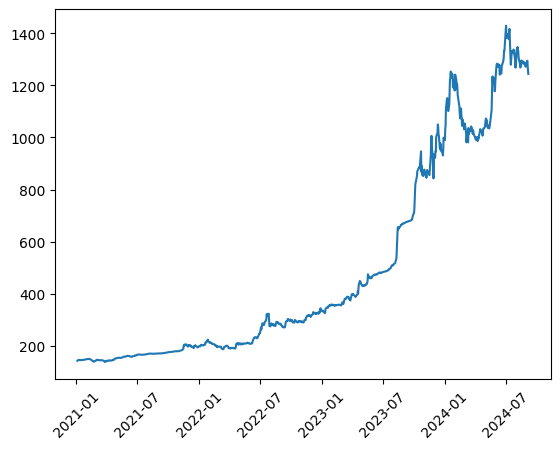

In [550]:
# plot dolar mep over last year since 2023-01-01
import matplotlib.pyplot as plt


plt.plot(dolar_mep["fechaHora_date"], dolar_mep["dolar_mep"])

# vertical ticks axis
plt.xticks(rotation=45)

plt.show()

In [551]:
# read price data
df_prices = pd.read_csv(
    "data/historical_prices.csv",
    parse_dates=["fechaHora_date"],
)

In [552]:
df_prices[df_prices["symbol"] == "VIST"].to_clipboard()

In [553]:
df_merged_VISTA = df_merged[df_merged["simbolo"] == "VIST"].copy()

# join prices
df_merged_VISTA = pd.merge(
    df_merged_VISTA,
    df_prices,
    how="inner",
    left_on=["fecha_operada", "simbolo"],
    right_on=["fechaHora_date", "symbol"],
)

In [554]:
# calculate total value
df_merged_VISTA["total_value"] = (
    df_merged_VISTA["total_qty"] * df_merged_VISTA["ultimoPrecio"]
)

In [555]:
df_merged_VISTA

,fecha_operada,cantidadOperada,precioOperado,montoOperado,simbolo,min_date,market,total_qty,symbol,fechaHora_date,ultimoPrecio,total_value
0,2023-03-10,7.0,7040.5,49283.5,VIST,2023-03-10,NaN,7.0,VIST,2023-03-10,7127.5,49892.5
1,2023-03-13,NaN,NaN,NaN,VIST,2023-03-10,NaN,7.0,VIST,2023-03-13,6851.0,47957.0
2,2023-03-14,NaN,NaN,NaN,VIST,2023-03-10,NaN,7.0,VIST,2023-03-14,6932.0,48524.0
3,2023-03-15,NaN,NaN,NaN,VIST,2023-03-10,NaN,7.0,VIST,2023-03-15,6468.0,45276.0
4,2023-03-16,NaN,NaN,NaN,VIST,2023-03-10,NaN,7.0,VIST,2023-03-16,6846.0,47922.0
...,...,...,...,...,...,...,...,...,...,...,...,...
359,2024-09-02,NaN,NaN,NaN,VIST,2023-03-10,NaN,232.0,VIST,2024-09-02,23075.0,5353400.0
360,2024-09-03,20.0,21775.0,435500.0,VIST,2023-03-10,NaN,252.0,VIST,2024-09-03,21450.0,5405400.0
361,2024-09-04,NaN,NaN,NaN,VIST,2023-03-10,NaN,252.0,VIST,2024-09-04,21450.0,5405400.0
362,2024-09-05,NaN,NaN,NaN,VIST,2023-03-10,NaN,252.0,VIST,2024-09-05,20625.0,5197500.0


In [556]:
dolar_mep = dolar_mep[["fechaHora_date", "dolar_mep"]].copy()
# convert to date
dolar_mep["fechaHora_date"] = pd.to_datetime(dolar_mep["fechaHora_date"])

In [557]:
# join dolar mep
df_merged_VISTA = pd.merge(
    df_merged_VISTA,
    dolar_mep,
    how="left",
    on="fechaHora_date",
)

df_merged_VISTA["total_value_usd"] = (
    df_merged_VISTA["total_value"] / df_merged_VISTA["dolar_mep"]
)

In [558]:
# daily total_qty_variation
df_merged_VISTA["total_qty_variation"] = df_merged_VISTA["total_qty"].diff()

In [560]:
df_merged_VISTA.reset_index().to_clipboard()

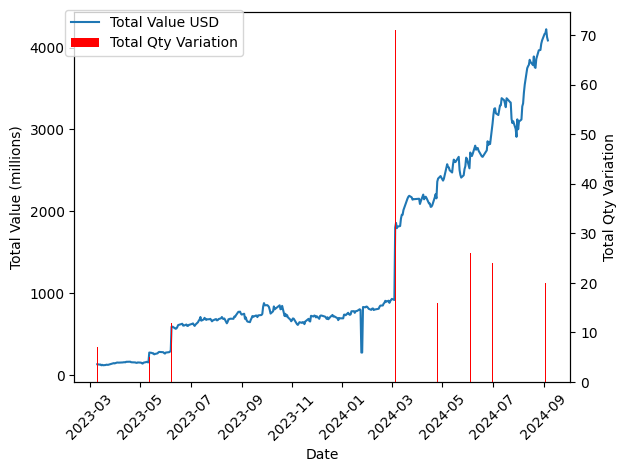

In [539]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the default style
plt.style.use("default")

# Create a figure and a set of subplots with secondary y-axis
fig, ax1 = plt.subplots()

# Plot the first dataset on the primary y-axis
ax1.plot(
    df_merged_VISTA["fechaHora_date"],
    df_merged_VISTA["total_value_usd"],
    label="Total Value USD",
)

ax1.set_xlabel("Date")
ax1.set_ylabel("Total Value (millions)")
ax1.tick_params(axis="x", rotation=45)

# Create a secondary y-axis
ax2 = ax1.twinx()

# Plot the second dataset on the secondary y-axis with increased bar width
ax2.bar(
    df_merged_VISTA["fechaHora_date"],
    df_merged_VISTA["cantidadOperada"],
    color="red",
    width=0.8,
    label="Total Qty Variation",
)
ax2.set_ylabel("Total Qty Variation")

# Add legends
fig.legend(loc="upper left", bbox_to_anchor=(0.1, 0.9))

# Show the plot
plt.show()

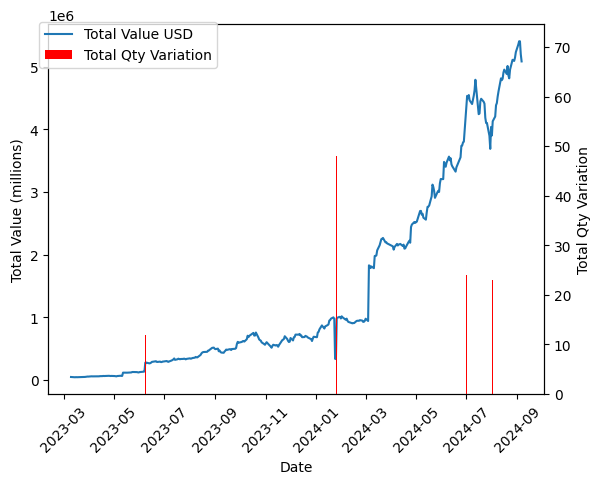

In [540]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the default style
plt.style.use("default")

# Create a figure and a set of subplots with secondary y-axis
fig, ax1 = plt.subplots()

# Plot the first dataset on the primary y-axis
ax1.plot(
    df_merged_VISTA["fechaHora_date"],
    df_merged_VISTA["total_value"],
    label="Total Value USD",
)

ax1.set_xlabel("Date")
ax1.set_ylabel("Total Value (millions)")
ax1.tick_params(axis="x", rotation=45)

# Create a secondary y-axis
ax2 = ax1.twinx()

# Plot the second dataset on the secondary y-axis with increased bar width
ax2.bar(
    df_merged_VISTA["fechaHora_date"],
    df_merged_VISTA["cantidadOperada"],
    color="red",
    width=0.8,
    label="Total Qty Variation",
)
ax2.set_ylabel("Total Qty Variation")

# Add legends
fig.legend(loc="upper left", bbox_to_anchor=(0.1, 0.9))

# Show the plot
plt.show()